## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

This project aims to conduct and analyze the results of an A/B test run by an e-commerce website to help decide whether to implement a new page, keep the old page, or perhaps run the experiment longer.

The data used includes:
* user_id
* timestamp
* group (control or treatment)
* landing_page (old_page or new_page)
* converted (1,0, with 1 meaning converted)


***
<a id='probability'></a>
### Part I - Probability

Read in the libraries

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset and take a look at the top few rows

In [5]:
df = pd.read_csv('./data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset.

In [6]:
df.shape[0]

294478

The number of unique users in the dataset.

In [7]:
df['user_id'].nunique()

290584

Duration of the experiment (first and last recorded date)

In [8]:
df['timestamp'].min(), df['timestamp'].max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

The proportion of users converted.

In [9]:
df['converted'].value_counts(normalize=True)[1]

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [10]:
# See the groupings of landing_page vs group
ct = pd.crosstab(df['landing_page'],df['group'])
ct

group,control,treatment
landing_page,,
new_page,1928,145311
old_page,145274,1965


In [11]:
# The number of times new_page and treatment don't line up
ct.loc['new_page','control'] + ct.loc['old_page','treatment']

3893

Check for missing values

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


*None of the rows have missing values*

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  The rows will therefore be removed as we cannot feel confident on the accuracy of the data.

In [13]:
# create dataframe of just those individuals that were part of the control group AND landed on the old page
df_ctrl = df[df['group']=='control']
df_ctrl = df_ctrl[df_ctrl['landing_page']=='old_page']
df_ctrl.shape

(145274, 5)

In [14]:
# create dataframe of just those individuals that were part of the treatment group AND landed on the new page
df_trt = df[df['group']=='treatment']
df_trt = df_trt[df_trt['landing_page']=='new_page']
df_trt.shape

(145311, 5)

In [15]:
# Create a new dataframe, df2
# Join the two dataframe df_ctrl and df_trt so 
# only rows where treatment is aligned with new_page 
# and control is aligned with old_page
df2 = pd.concat([df_ctrl, df_trt])
df2.shape

(290585, 5)

In [16]:
# Check the first few lines of new dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [17]:
# check to see if df2 has only treatment aligned with new_page and control aligned with old_page
pd.crosstab(df2['landing_page'],df2['group'])

group,control,treatment
landing_page,,
new_page,0,145311
old_page,145274,0


In [18]:
# Double Check all of the correct rows were removed - this should be 0 - check treatment group
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [19]:
# Double Check all of the correct rows were removed - this should be 0 - check control group
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

Number of unique **user_id**s are in **df2**

In [20]:
df2['user_id'].nunique()

290584

The **user_id** repeated in **df2**

In [21]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Row information for the repeat **user_id**

In [22]:
df2[df2['user_id']==df2[df2['user_id'].duplicated()].iloc[0]['user_id']]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the duplicated rows

In [23]:
df2.drop_duplicates(['user_id'], inplace=True)

#Check for duplicate
sum(df2['user_id'].duplicated())

0

In [24]:
# Check how many unique user_id after dropping the duplicate
df2['user_id'].nunique()

290584

The probability of an individual converting regardless of the page they receive

In [25]:
# Conversion is denoted 1
df2['converted'].value_counts(normalize=True)

0    0.880403
1    0.119597
Name: converted, dtype: float64

Given that an individual was in the `control` group, the probability they converted

In [26]:
# Conversion is denoted 1 
df2[df2['group']=='control']['converted'].value_counts(normalize=True)

0    0.879614
1    0.120386
Name: converted, dtype: float64

Given that an individual was in the `treatment` group, the probability they converted

In [27]:
# Conversion is denoted 1
df2[df2['group']=='treatment']['converted'].value_counts(normalize=True)

0    0.881192
1    0.118808
Name: converted, dtype: float64

The probability that an individual received the new page

In [28]:
df2['landing_page'].value_counts(normalize=True)

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

* There is an even proportion of users in each group - almost half of the individuals belonging to the treatment group and receiving the new page (0.500062) and half the individuals belonging to the control group receiving the old page (0.499938)

* Of those in the treatment group, the probability of conversion is 0.1189 

* The conversion rate in the treatment group is consistent with the overall conversion rate for the entire dataset (0.1196)

* The probability of conversion for the treatment group is lower than the probability of conversion in the control group of 0.1204

From this initial analysis there doesn't seem to be any evidence that the new treatment page leads to more conversions compared to the entire sample and more specifically compared to the control group who received the old page.  The probability of conversion from the treatment page is actually lower than the probability of conversion from the control page.  

However, we haven't yet measured how confident we are in these results.  Furthermore, we should check whether this sample is a good representation of the population by seeing if the results can be replicated.  Replication and a variety of well-designed tests will create a body of evidence to support the findings

***
<a id='ab_test'></a>
### Part II - A/B Test

**Hypotheses**

If we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, then:

$$H_0: p_{new} - p_{old} \le 0$$
$$H_1: p_{new} - p_{old} > 0$$

$$\alpha = 0.05$$

The **convert rate** for $p_{new}$ under the null

In [29]:
df2['converted'].value_counts(normalize=True)

0    0.880403
1    0.119597
Name: converted, dtype: float64

In [30]:
p_new = df2['converted'].value_counts(normalize=True)[1]
print('p_new = {}'.format(p_new))

p_new = 0.11959708724499628


The **convert rate** for $p_{old}$ under the null?

In [31]:
# Based on the assumption that under the null hypothesis, 
# 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 both have "true" success rates equal to the converted success rate regardless of page - 
# that is 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 are equal
p_old = p_new
print('p_old = {}'.format(p_old))

p_old = 0.11959708724499628


$n_{new}$

In [32]:
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [33]:
n_new = df2['landing_page'].value_counts()[0]
print('n_new = {}'.format(n_new))

n_new = 145310


$n_{old}$

In [34]:
n_old = df2['landing_page'].value_counts()[1]
print('n_old = {}'.format(n_old))

n_old = 145274


Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. 

In [35]:
# Since there are only two outcomes, 1 or 0, we can simulate using the binomial distribution
new_page_converted = np.random.binomial(1, p_new, n_new)
np.unique(new_page_converted, return_counts=True)

(array([0, 1]), array([128225,  17085], dtype=int64))

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [36]:
# Another way to simulate 1 and 0 is to specify these as possible outcomes using random.choice
# p needs to be specified correctly that p_old is the probability associated with generating 1
old_page_converted = np.random.choice((0,1), size=(n_old,1), replace=True, p=[(1-p_old), p_old])
np.unique(old_page_converted, return_counts=True)

(array([0, 1]), array([127898,  17376], dtype=int64))

$p_{new}$ - $p_{old}$ for the simulated values

In [37]:
p_new = np.mean(new_page_converted)
p_old = np.mean(old_page_converted)
p_new, p_old

(0.11757621636501273, 0.11960846400594738)

In [38]:
p_new - p_old

-0.0020322476409346535

Simulate 10,000 $p_{new}$ - $p_{old}$ values

In [39]:
# Based on the assumption that under the null hypothesis, 
# convert rate is equal for the control and treatment group regardless of page
convert_rate = df2['converted'].value_counts(normalize=True)[1]
convert_rate

0.11959708724499628

In [40]:
converted_new = np.random.binomial(n_new, convert_rate, int(1e4))/n_new
converted_old = np.random.binomial(n_old, convert_rate, int(1e4))/n_old
p_diffs = (converted_new - converted_old)

**Histogram of the p_diffs**  

Under the null hypothesis, the distribution of the difference in conversion rates between the old and new page (ie **p_diffs**)  would be approximately normal


The observed difference of conversion rate between new and old page

In [41]:
p_act_new = df2[df2['landing_page']=='new_page']['converted'].value_counts(normalize=True)[1]
p_act_old = df2[df2['landing_page']=='old_page']['converted'].value_counts(normalize=True)[1]
p_diffs_actual = p_act_new - p_act_old

Plot p_diffs and the observed difference

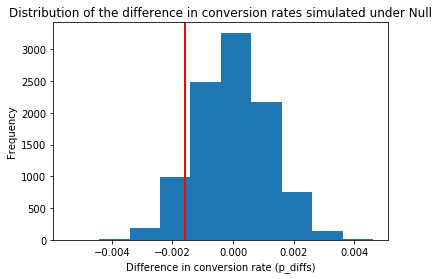

In [42]:
plt.hist(p_diffs)
plt.axvline(x= p_diffs_actual, color='r', lw=2)
plt.title('Distribution of the difference in conversion rates simulated under Null')
plt.xlabel('Difference in conversion rate (p_diffs)')
plt.ylabel('Frequency');

Proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**

In [43]:
(p_diffs > p_diffs_actual).mean()

0.9075

***p-value and Conclusion***

The calculated 0.904 above is the p-value, which is the probability of the observed value (p_diffs_actual), or one more extreme in favour of the alternative hypothesis, given the null hypothesis is true

The alternative hypothesis is that the difference between the conversion rate on the new and old page is greater than 0, therefore we are concerned with the area and p_diffs to the right of (greater than) the observed value, shown by the red line and is p_diffs_actual.

The p-value of 0.904 calcuated above is much greater than our set Type I error threshold $\alpha = 0.05$.  So we would fail to reject the null hypothesis.  There is no evidence to suggest the new page is better than the old page with regards to conversion rates.

#### Compare results with built in Z-Test

Read in statsmodels

In [44]:
import statsmodels.api as sm

In [45]:
# Create a crosstab table that groups number of conversion based on group
ct_group_convert = pd.crosstab(df2['group'],df['converted'])

In [46]:
#Number of conversions for the control group
convert_old = ct_group_convert.loc['control',1]
# Number of conversions for the treatment group
convert_new = ct_group_convert.loc['treatment',1]
# Number of rows associated with the old and new pages
n_old = df2['landing_page'].value_counts()[1]
n_new = df2['landing_page'].value_counts()[0]

Use `stats.proportions_ztest` to compute the test statistic and p-value.

In [47]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
z_stat, pval = proportions_ztest(count, nobs, alternative='smaller')
z_stat, pval

(1.3109241984234394, 0.9050583127590245)

***Conclusion***

At the significance level $\alpha = 0.05$, the critical value is Z=1.645

As we have an alternative hypothesis $H_1: p_{new} - p_{old} > 0$,  that there would be an increase in conversion with the new page, our test is an upper-tailed test.  

The decision rule is: Reject $H_0$ if Z $\ge$ 1.645

Our z-score is 1.311, therefore on this basis we fail to reject the null

The z-score and more specifically p-value (0.905) are consistent with the proportion of p_diffs greater than the actual observed difference of 0.904 calculated via the bootstrap method.


***
<a id='regression'></a>
### Part III - A regression approach



As we are predicting for only two outcomes (conversion or no conversion), a ***logistic regression model*** will be used

In [48]:
# First 5 rows of df2
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [49]:
#Add intercept column
df2['intercept']=1

In [50]:
# Add ab_page column, which is 1 when an individual receives the treatment and 0 if control
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('control', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


Use **statsmodels** to import the regression model.  

In [51]:
# Instantiate  and fit the logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

# Summary of logistic regression model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        22:39:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**** The p-value associated with ab_page is 0.19.  As this is higher than the 0.05 significance level, we would fail to reject the null.  

Furthermore, this p-value differs from the p-value found in Part II A/B Testing due to the null hypothesis for each method:
* The null hypothesis for the A/B Test is one tail - the difference between conversion rates of the new and old page is less than or equal to 0, with evidence for the alternative found in the left tail.
* On the other hand, the null hypothesis for the regression model is two tailed - there is no difference between the new and old tail, with evidence for the alternative found in the two tails of the distribution.

We can convert the two-tail p-value from the regression model into a one-tail p-value to compare with p-value found earlier in the A/B Testing section.

In [52]:
# Two tail p-value 
p_val_ab = results.pvalues[1]

#Convert to one-tail p-value.  
p_val_ab / 2 #

0.09494310561811792

In [53]:
# Our one tail Alternative Hypothesis is concerned with the area to the right of the observed difference
1-_

0.9050568943818821

This converted p-value of 0.905 is consistent with the p-values calculated in Part II A/B Testing of 0.904 (bootstrap method) and 0.905 (z-test).

**Analyzing Multiple Metrics**

Adding more factors to the model could increase its predictive power in determining conversion or not

However similar to running multiple tests, evaluating too many variables increases the likelihood of observing significant differences just by chance.  Using the Bonferroni correction may help decrease this likelihood

Adding additional variables to your regression model may also cause problems should they end up being correlated with other x-variables.  This results in unstable coefficients, which may cause the predictive value of a particular x-variable to be unrealized or even flipped to what would be expected in bivariate regression relationships.

Furthermore, the significance of the value added to the predictive power of the model by including more variables must be weighed up against the logistics in obtaining the data.

Therefore adding the 'right' variables should be of higher importance than merely adding more.

**Testing country effect on conversion rates**

We can test the relationship of a user's country with the dependent variable 'converted' using additional data.

Read in countries.csv data and join to our existing data

In [54]:
countries_df = pd.read_csv('./data/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [55]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [56]:
#Fit the model and show results
log_m = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results_countries = log_m.fit()
results_countries.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        22:39:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**** The countries variables did not produce staistically significant results with p-values greater than $\alpha = 0.05$.  It therefore does not appear that country had an impact on conversion.



**Interaction between page and country**

In [57]:
# Create interaction columns between each individual country and ab_page.  US will again be treated as baseline
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']

In [58]:
### Fit the Model And Obtain the Results
log_m = sm.Logit(df_new['converted'], df_new[['intercept', 'CA_page', 'UK_page', 'CA', 'UK','ab_page']])
results = log_m.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 01 Jul 2019   Pseudo R-squ.:               3.482e-05
Time:                        22:39:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
==============================================================================
"""

Country, page and country-page interaction are found in this model to **not** be statistically significant in relating to the response variable of conversion with p-values all greater than $\alpha = 0.05$

***
<a id='conclusions'></a>
## Conclusions

Based on the available data and consistent across the methods used in this analysis: probability, A/B testing and regression models, there is insufficient evidence to support that the new page is better than the old page in impacting conversions.  

Furthermore in the initial analysis, it was found that the old page had a slightly higher conversion rate than the new page.

Additional analysis was conducted to determine whether a user's country had any relationship with conversion, but this metric was not found to be statistically significant.

As this experiment was run for just under a month in January, it may be beneficial to run the experiment longer in order to account for seasonal effects on change in behaviour due to this being the start of the year.  Additionally a longer duration for the experiment might also determine whether a novelty effect or change aversion was at play.  



***
## Resources

[how to bootstrap 10,000 iterations using binomial](https://study-hall.udacity.com/rooms/community:nd002:594140-project-355/community:thread-11706659296-500489?contextType=room)

[statsmodels.proportions_ztest](https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html)

[how to set up z-test](https://knowledge.udacity.com/questions/26449)

[Hypothesis Testing: Upper, Lower and Two-Tailed (Explanation of Z-Test)](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html)

[Hypothesis test: Difference in means](https://stattrek.com/hypothesis-test/difference-in-means.aspx)

[Hypothesis test: Difference in proportions](https://stattrek.com/hypothesis-test/difference-in-proportions.aspx)

[p-values](https://rebeccaebarnes.github.io/2018/05/01/what-is-a-p-value)

[What is a p-value in layman's terms](https://www.quora.com/What-is-a-p-value-explained-in-layman%E2%80%99s-terms)

[Convert p-values: One-tail and Two-tail](https://www.graphpad.com/guides/prism/7/statistics/one-tail_vs__two-tail_p_values.htm?toc=0&printWindow)

[how to set up interaction effect](https://knowledge.udacity.com/questions/38871)

[Peer project](https://github.com/rebeccaebarnes/DAND-Project-4/blob/master/Analyze_ab_test_results_notebook.ipynb)

[Peer project](https://github.com/nirupamaprv/Analyze-AB-test-Results/blob/master/Analyze_ab_test_results_notebook.ipynb)

Rowntree, Derek.  Statistics without Tears (Penguin Books 1981)

Rumsey, Deborah.  Statistics for Dummies. (Wiley Publishing 2011)

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0